## Task 3 : Customer Segmentation / Clustering

### **Prerequisites**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### **Data loading**

In [ ]:
# 1. Data Loading
customers_path = '/content/drive/MyDrive/ZeoTap/Customers.csv'
transactions_path = '/content/drive/MyDrive/ZeoTap/Transactions.csv'

customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)

### **Data Preprocessing**

In [ ]:
# 2. Data Preprocessing
# Merge customer and transaction data on CustomerID
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

# Aggregate transaction data for each customer
transaction_features = merged_df.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count'],  # Total, average, and count of transactions
    'ProductID': 'nunique'  # Number of unique products purchased
}).reset_index()
transaction_features.columns = ['CustomerID', 'TotalSpent', 'AverageSpent', 'TransactionCount', 'UniqueProducts']

# Merge transaction features with customer profiles
customer_data = pd.merge(customers_df, transaction_features, on='CustomerID', how='inner')

# Drop non-numeric columns for clustering
clustering_data = customer_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)

# One-hot encode categorical variables (e.g., Region)
clustering_data = pd.get_dummies(clustering_data, columns=['Region'], drop_first=True)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

### **Clustering**

In [ ]:
# 3. Clustering
# Try different numbers of clusters and evaluate with Davies-Bouldin Index
cluster_range = range(2, 11)
db_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, cluster_labels)
    db_scores.append((n_clusters, db_index))

# Select the optimal number of clusters with the lowest DB Index
optimal_clusters = min(db_scores, key=lambda x: x[1])[0]

# Final clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

### **Evaluation Metrics**

In [ ]:
# 4. Evaluation Metrics
print("Optimal Number of Clusters:", optimal_clusters)
print("Davies-Bouldin Index:", min(db_scores, key=lambda x: x[1])[1])

### **Visualization**

Optimal Number of Clusters: 8
Davies-Bouldin Index: 1.0384341885677233


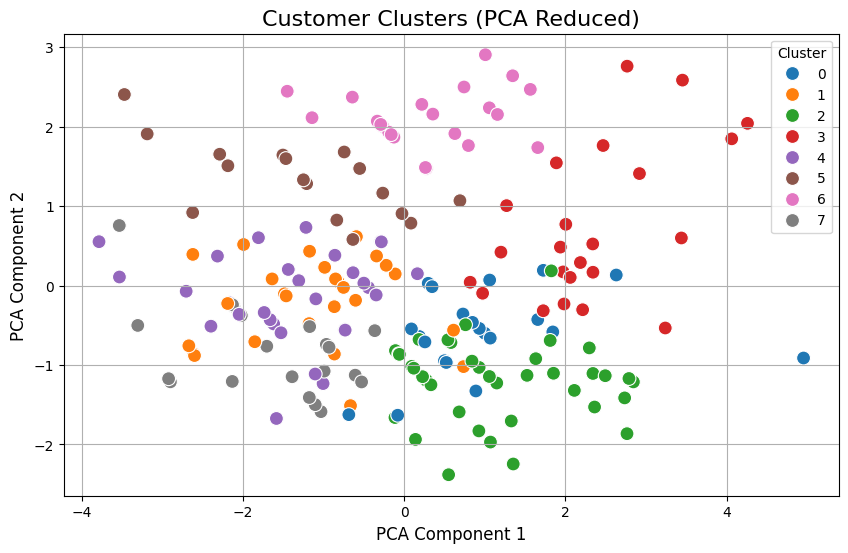

Clustering results saved to 'CustomerClusters.csv'


In [ ]:
# 5. Visualization
# Reduce dimensions for plotting
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
customer_data['PCA1'] = reduced_data[:, 0]
customer_data['PCA2'] = reduced_data[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='tab10', s=100
)
plt.title('Customer Clusters (PCA Reduced)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Save the clustering results
customer_data[['CustomerID', 'Cluster']].to_csv('/content/drive/MyDrive/ZeoTap/CustomerClusters.csv', index=False)
print("Clustering results saved to 'CustomerClusters.csv'")
